In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

plt.style.use("seaborn-white")
import seaborn as sns

sns.set_style("white")

from sklearn.model_selection import train_test_split

from torch import nn

In [2]:
from data import prepare_data, TGSSaltDataset
from model import model_path, save_checkpoint, update_state, predict_tta
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import torch

from torch.utils import data

from resnetlike import UNetResNet
from training import train, test
from collections import defaultdict
import logging
import random
from utils import create_optimizer, tboard_log_path
import uuid
import itertools as it
from operator import itemgetter
import shutil
from losses import lovasz_hinge
from metrics import my_iou_metric
from tensorboardX import SummaryWriter
from tqdm import tqdm
from visualisation import plot_poor_predictions
import torch.nn as nn
from visualisation import plot_predictions
from metrics import iou_metric_batch
from training import RefineStep
from config import load_config, save_config

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
now = datetime.datetime.now()

In [5]:
config = load_config()['RefineModel']
logger.info(f'Loading config {config}')

INFO:config:Loading config ../configs/config.json
INFO:__main__:Loading config {'base_channels': 32, 'batch_size': 128, 'best_model_filename': 'best_lovasz_model.pth', 'epochs': 200, 'id': '61464e07-ce3e-42b1-b88a-482d645756d8', 'img_target_size': 101, 'initial_model_filename': 'best_model_state.pth', 'model_filename': 'model_lovasz_state', 'name': 'RefineModel', 'num_workers': 0, 'optimization_config': {'learning_rate': 0.001, 'scheduler': {'lr_min': 0, 'num_cycles': 6, 'type': 'cosine'}, 'type': 'adam'}, 'seed': 42}


In [6]:
locals().update(config)

In [7]:
# img_size_target = 101
# batch_size = 128
# learning_rate = 0.001
# epochs = 200
# num_workers = 0
# seed = 42
# notebook_id = f"{now:%d%b%Y}_{uuid.uuid4()}"
# base_channels = 32
# optim_config = {
#     "optimizer": "sgd",
#     "base_lr": 0.01,
#     "momentum": 0.9,
#     "weight_decay": 1e-4,
#     "nesterov": True,
#     "epochs": epochs,
#     "scheduler": "cosine",
#     "lr_min": 0,
# }

In [8]:
torch.backends.cudnn.benchmark = True
logger.info(f"Started {now}")
tboard_log = os.path.join(tboard_log_path(), f"log_{id}")
logger.info(f"Writing TensorBoard logs to {tboard_log}")
summary_writer = None#SummaryWriter(log_dir=tboard_log)

INFO:__main__:Started 2018-10-05 11:37:30.597317
INFO:__main__:Writing TensorBoard logs to /mnt/models/logs/pytorch_unet_resnetlike/bd788921eaa0c41ffafd30b72c4e312ba12e01e3/log_61464e07-ce3e-42b1-b88a-482d645756d8


In [9]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [10]:
model = UNetResNet(1, base_channels)

In [11]:
n_params = sum([param.view(-1).size()[0] for param in model.parameters()])
logger.info("n_params: {}".format(n_params))

INFO:__main__:n_params: 20419744


In [12]:
device = torch.device("cuda:0")
model = nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): UNetResNet(
    (enc1): EncodingLayer(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (res1): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (res2): PreactivationResidualBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias

In [13]:
model_dir=os.path.join(model_path(), f"{id}")
filename = os.path.join(model_dir, initial_model_filename)
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

In [14]:
model.module.final_activation=nn.Sequential().to(device)

In [15]:
train_df, test_df = prepare_data()
train_df.head()

100%|██████████| 4000/4000 [00:01<00:00, 2443.15it/s]


,z,images,masks,coverage,coverage_class
id,,,,,
575d24d81d,843,"[[0.5254901960784314, 0.5137254901960784, 0.52...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,0
a266a2a9df,794,"[[0.3411764705882353, 0.3764705882352941, 0.33...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.504950,6
75efad62c1,468,"[[0.5686274509803921, 0.4666666666666667, 0.32...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.993334,10
34e51dba6a,727,"[[0.5411764705882353, 0.4745098039215686, 0.39...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.149201,2
4875705fb0,797,"[[0.06666666666666667, 0.0784313725490196, 0.0...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.042839,1


In [16]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.tolist()).reshape(
        -1, 1, img_target_size, img_target_size
    ),
    np.array(train_df.masks.tolist()).reshape(
        -1, 1, img_target_size, img_target_size
    ),
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2,
    stratify=train_df.coverage_class,
    random_state=seed,
)

In [17]:
# Augment data with flipped verisons
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)
x_train.shape

(6400, 1, 101, 101)

In [18]:
dataset = TGSSaltDataset(x_train, y_data=y_train)
dataset_val = TGSSaltDataset(x_valid, y_data=y_valid)

In [19]:
train_data_loader = data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=True,
)
val_data_loader = data.DataLoader(
    dataset_val,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True,
    drop_last=False,
)

In [20]:
state = {
    "state_dict": None,
    "optimizer": None,
    "epoch": 0,
    "val_iou": 0,
    "best_val_iou": 0,
    "best_epoch": 0,
}

In [21]:
metrics=(('iou', my_iou_metric(threshold=0)),)
loss_fn = lovasz_hinge
optimizer = torch.optim.Adam(model.parameters(), lr=optimization_config['learning_rate'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, threshold=0.0001)

In [22]:
step_func = RefineStep(loss_fn, scheduler, optimizer, summary_writer=summary_writer, metrics_func=metrics, output_threshold=0)

In [23]:
lovasz_history = defaultdict(list)
for epoch in range(epochs):
    train_metrics = train(
        epoch,
        model,
        train_data_loader,
        step_func,
        summary_writer=summary_writer
    )

    val_metrics = test(
        epoch,
        model,
        loss_fn,
        val_data_loader,
        summary_writer=summary_writer,
        metrics_funcs=metrics,
        output_threshold=0
    )
    scheduler.step(np.mean(val_metrics["loss"]))
    state = update_state(
        state, epoch, "val_iou", np.mean(val_metrics["iou"]), model, optimizer
    )

    save_checkpoint(
        state, outdir=model_dir, model_filename=model_filename, best_model_filename=best_model_filename
    )

    lovasz_history["epoch"].append(epoch)
    lovasz_history["train_loss"].append(np.mean(train_metrics["loss"]))
    lovasz_history["val_loss"].append(np.mean(val_metrics["loss"]))
    lovasz_history["train_iou"].append(np.mean(train_metrics["iou"]))
    lovasz_history["val_iou"].append(np.mean(val_metrics["iou"]))

INFO:training:Train 0
INFO:training:Epoch: 0,Train: loss 0.835,  IoU 0.640
INFO:training:Elapsed 34.36
INFO:training:Test 0
INFO:training:Epoch: 0,Val: loss 0.540, IoU 0.606 ** 
INFO:training:Elapsed 1.53
INFO:model:val_iou went from 0 to 0.60625 >:)
INFO:training:Train 1
INFO:training:Epoch: 1,Train: loss 0.624,  IoU 0.682
INFO:training:Elapsed 18.08
INFO:training:Test 1
INFO:training:Epoch: 1,Val: loss 0.593, IoU 0.609 ** 
INFO:training:Elapsed 1.24
INFO:model:val_iou went from 0.60625 to 0.609375 >:)
INFO:training:Train 2
INFO:training:Epoch: 2,Train: loss 0.625,  IoU 0.687
INFO:training:Elapsed 16.21
INFO:training:Test 2
INFO:training:Epoch: 2,Val: loss 0.631, IoU 0.587 ** 
INFO:training:Elapsed 1.30
INFO:training:Train 3
INFO:training:Epoch: 3,Train: loss 0.613,  IoU 0.690
INFO:training:Elapsed 16.02
INFO:training:Test 3
INFO:training:Epoch: 3,Val: loss 0.604, IoU 0.562 ** 
INFO:training:Elapsed 1.22
INFO:training:Train 4
INFO:training:Epoch: 4,Train: loss 0.570,  IoU 0.701
INFO:t

INFO:training:Elapsed 16.01
INFO:training:Test 37
INFO:training:Epoch: 37,Val: loss 0.418, IoU 0.697 ** 
INFO:training:Elapsed 1.27


Epoch    37: reducing learning rate of group 0 to 1.0000e-04.


INFO:training:Train 38
INFO:training:Epoch: 38,Train: loss 0.435,  IoU 0.754
INFO:training:Elapsed 16.04
INFO:training:Test 38
INFO:training:Epoch: 38,Val: loss 0.397, IoU 0.691 ** 
INFO:training:Elapsed 1.25
INFO:training:Train 39
INFO:training:Epoch: 39,Train: loss 0.419,  IoU 0.760
INFO:training:Elapsed 16.27
INFO:training:Test 39
INFO:training:Epoch: 39,Val: loss 0.397, IoU 0.691 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 40
INFO:training:Epoch: 40,Train: loss 0.413,  IoU 0.764
INFO:training:Elapsed 16.03
INFO:training:Test 40
INFO:training:Epoch: 40,Val: loss 0.393, IoU 0.700 ** 
INFO:training:Elapsed 1.22
INFO:training:Train 41
INFO:training:Epoch: 41,Train: loss 0.414,  IoU 0.764
INFO:training:Elapsed 16.05
INFO:training:Test 41
INFO:training:Epoch: 41,Val: loss 0.390, IoU 0.719 ** 
INFO:training:Elapsed 1.25
INFO:model:val_iou went from 0.715625 to 0.71875 >:)
INFO:training:Train 42
INFO:training:Epoch: 42,Train: loss 0.419,  IoU 0.761
INFO:training:Elapsed 16.05
INFO:t

INFO:training:Elapsed 1.24


Epoch    75: reducing learning rate of group 0 to 1.0000e-05.


INFO:training:Train 76
INFO:training:Epoch: 76,Train: loss 0.366,  IoU 0.785
INFO:training:Elapsed 16.04
INFO:training:Test 76
INFO:training:Epoch: 76,Val: loss 0.359, IoU 0.756 ** 
INFO:training:Elapsed 1.25
INFO:training:Train 77
INFO:training:Epoch: 77,Train: loss 0.357,  IoU 0.790
INFO:training:Elapsed 15.99
INFO:training:Test 77
INFO:training:Epoch: 77,Val: loss 0.362, IoU 0.759 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 78
INFO:training:Epoch: 78,Train: loss 0.360,  IoU 0.789
INFO:training:Elapsed 16.00
INFO:training:Test 78
INFO:training:Epoch: 78,Val: loss 0.361, IoU 0.756 ** 
INFO:training:Elapsed 1.29
INFO:training:Train 79
INFO:training:Epoch: 79,Train: loss 0.358,  IoU 0.790
INFO:training:Elapsed 15.97
INFO:training:Test 79
INFO:training:Epoch: 79,Val: loss 0.356, IoU 0.759 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 80
INFO:training:Epoch: 80,Train: loss 0.361,  IoU 0.789
INFO:training:Elapsed 16.03
INFO:training:Test 80
INFO:training:Epoch: 80,Val: loss 0.3

Epoch    86: reducing learning rate of group 0 to 1.0000e-06.


INFO:training:Train 87
INFO:training:Epoch: 87,Train: loss 0.351,  IoU 0.794
INFO:training:Elapsed 16.05
INFO:training:Test 87
INFO:training:Epoch: 87,Val: loss 0.357, IoU 0.759 ** 
INFO:training:Elapsed 1.30
INFO:training:Train 88
INFO:training:Epoch: 88,Train: loss 0.356,  IoU 0.792
INFO:training:Elapsed 15.96
INFO:training:Test 88
INFO:training:Epoch: 88,Val: loss 0.355, IoU 0.747 ** 
INFO:training:Elapsed 1.22
INFO:training:Train 89
INFO:training:Epoch: 89,Train: loss 0.355,  IoU 0.794
INFO:training:Elapsed 15.98
INFO:training:Test 89
INFO:training:Epoch: 89,Val: loss 0.356, IoU 0.763 ** 
INFO:training:Elapsed 1.27
INFO:training:Train 90
INFO:training:Epoch: 90,Train: loss 0.352,  IoU 0.794
INFO:training:Elapsed 15.97
INFO:training:Test 90
INFO:training:Epoch: 90,Val: loss 0.357, IoU 0.747 ** 
INFO:training:Elapsed 1.22
INFO:training:Train 91
INFO:training:Epoch: 91,Train: loss 0.352,  IoU 0.793
INFO:training:Elapsed 16.09
INFO:training:Test 91
INFO:training:Epoch: 91,Val: loss 0.3

Epoch   106: reducing learning rate of group 0 to 1.0000e-07.


INFO:training:Train 107
INFO:training:Epoch: 107,Train: loss 0.351,  IoU 0.794
INFO:training:Elapsed 16.01
INFO:training:Test 107
INFO:training:Epoch: 107,Val: loss 0.357, IoU 0.756 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 108
INFO:training:Epoch: 108,Train: loss 0.354,  IoU 0.793
INFO:training:Elapsed 15.98
INFO:training:Test 108
INFO:training:Epoch: 108,Val: loss 0.358, IoU 0.753 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 109
INFO:training:Epoch: 109,Train: loss 0.350,  IoU 0.794
INFO:training:Elapsed 15.95
INFO:training:Test 109
INFO:training:Epoch: 109,Val: loss 0.355, IoU 0.778 ** 
INFO:training:Elapsed 1.27
INFO:model:val_iou went from 0.775 to 0.778125 >:)
INFO:training:Train 110
INFO:training:Epoch: 110,Train: loss 0.361,  IoU 0.790
INFO:training:Elapsed 15.92
INFO:training:Test 110
INFO:training:Epoch: 110,Val: loss 0.358, IoU 0.753 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 111
INFO:training:Epoch: 111,Train: loss 0.353,  IoU 0.792
INFO:training:Elap

Epoch   117: reducing learning rate of group 0 to 1.0000e-08.


INFO:training:Train 118
INFO:training:Epoch: 118,Train: loss 0.357,  IoU 0.792
INFO:training:Elapsed 15.93
INFO:training:Test 118
INFO:training:Epoch: 118,Val: loss 0.354, IoU 0.753 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 119
INFO:training:Epoch: 119,Train: loss 0.357,  IoU 0.792
INFO:training:Elapsed 15.92
INFO:training:Test 119
INFO:training:Epoch: 119,Val: loss 0.357, IoU 0.747 ** 
INFO:training:Elapsed 1.22
INFO:training:Train 120
INFO:training:Epoch: 120,Train: loss 0.349,  IoU 0.795
INFO:training:Elapsed 16.02
INFO:training:Test 120
INFO:training:Epoch: 120,Val: loss 0.353, IoU 0.750 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 121
INFO:training:Epoch: 121,Train: loss 0.350,  IoU 0.794
INFO:training:Elapsed 15.96
INFO:training:Test 121
INFO:training:Epoch: 121,Val: loss 0.354, IoU 0.753 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 122
INFO:training:Epoch: 122,Train: loss 0.352,  IoU 0.795
INFO:training:Elapsed 15.96
INFO:training:Test 122
INFO:training:Epoc

INFO:training:Test 156
INFO:training:Epoch: 156,Val: loss 0.350, IoU 0.753 ** 
INFO:training:Elapsed 1.24
INFO:training:Train 157
INFO:training:Epoch: 157,Train: loss 0.351,  IoU 0.795
INFO:training:Elapsed 15.86
INFO:training:Test 157
INFO:training:Epoch: 157,Val: loss 0.355, IoU 0.759 ** 
INFO:training:Elapsed 1.22
INFO:training:Train 158
INFO:training:Epoch: 158,Train: loss 0.353,  IoU 0.793
INFO:training:Elapsed 15.96
INFO:training:Test 158
INFO:training:Epoch: 158,Val: loss 0.353, IoU 0.750 ** 
INFO:training:Elapsed 1.22
INFO:training:Train 159
INFO:training:Epoch: 159,Train: loss 0.356,  IoU 0.792
INFO:training:Elapsed 15.99
INFO:training:Test 159
INFO:training:Epoch: 159,Val: loss 0.357, IoU 0.747 ** 
INFO:training:Elapsed 1.27
INFO:training:Train 160
INFO:training:Epoch: 160,Train: loss 0.349,  IoU 0.795
INFO:training:Elapsed 15.86
INFO:training:Test 160
INFO:training:Epoch: 160,Val: loss 0.358, IoU 0.747 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 161
INFO:training:Epoc

INFO:training:Train 195
INFO:training:Epoch: 195,Train: loss 0.356,  IoU 0.793
INFO:training:Elapsed 15.74
INFO:training:Test 195
INFO:training:Epoch: 195,Val: loss 0.357, IoU 0.753 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 196
INFO:training:Epoch: 196,Train: loss 0.350,  IoU 0.794
INFO:training:Elapsed 15.84
INFO:training:Test 196
INFO:training:Epoch: 196,Val: loss 0.352, IoU 0.759 ** 
INFO:training:Elapsed 1.26
INFO:training:Train 197
INFO:training:Epoch: 197,Train: loss 0.353,  IoU 0.794
INFO:training:Elapsed 15.78
INFO:training:Test 197
INFO:training:Epoch: 197,Val: loss 0.355, IoU 0.753 ** 
INFO:training:Elapsed 1.20
INFO:training:Train 198
INFO:training:Epoch: 198,Train: loss 0.351,  IoU 0.794
INFO:training:Elapsed 15.81
INFO:training:Test 198
INFO:training:Epoch: 198,Val: loss 0.353, IoU 0.759 ** 
INFO:training:Elapsed 1.23
INFO:training:Train 199
INFO:training:Epoch: 199,Train: loss 0.358,  IoU 0.791
INFO:training:Elapsed 15.89
INFO:training:Test 199
INFO:training:Epoc

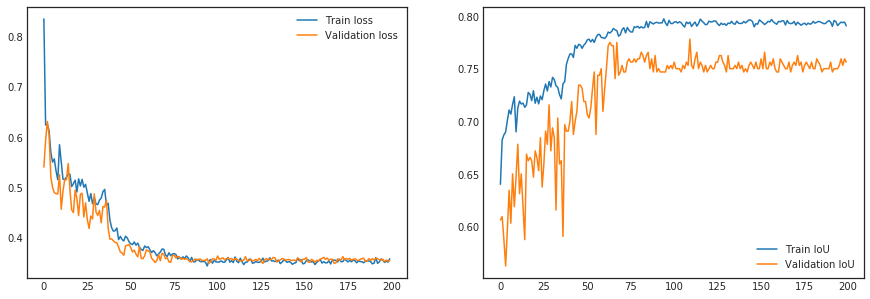

In [24]:
fig, (ax_loss, ax_iou) = plt.subplots(1, 2, figsize=(15, 5))
ax_loss.plot(lovasz_history["epoch"], lovasz_history["train_loss"], label="Train loss")
ax_loss.plot(
    lovasz_history["epoch"], lovasz_history["val_loss"], label="Validation loss"
)
ax_loss.legend()
ax_iou.plot(lovasz_history["epoch"], lovasz_history["train_iou"], label="Train IoU")
ax_iou.plot(lovasz_history["epoch"], lovasz_history["val_iou"], label="Validation IoU")
ax_iou.legend()

### Find Optimal Threshold

In [25]:
filename = os.path.join(model_dir, best_model_filename)
checkpoint = torch.load(filename)
model.load_state_dict(checkpoint["state_dict"])

100%|██████████| 7/7 [00:00<00:00,  8.25it/s]


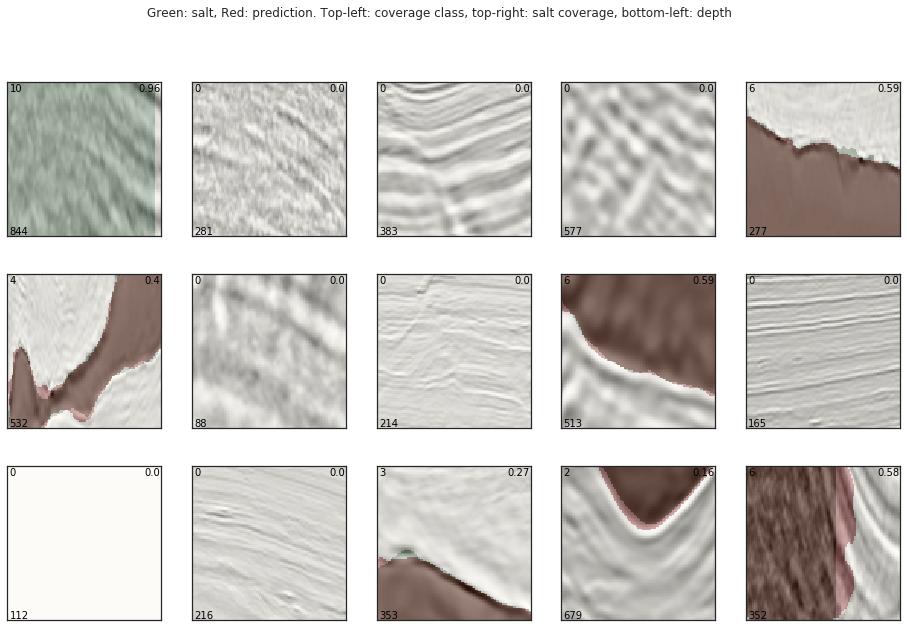

In [26]:
model.eval()
predictions = [predict_tta(model, image) for image, _ in tqdm(val_data_loader)]
preds_valid = np.concatenate(predictions, axis=0).squeeze()

preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > 0), dtype=np.float32),
    preds_valid,
)

preds_thresh = np.array(list(preds_thresh_iter))


plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

In [27]:
## Scoring for last model, choose threshold using validation data
thresholds = np.linspace(0.3, 0.7, 31)
y_valid_down = y_valid.squeeze()
thresholds = np.log(thresholds / (1 - thresholds))

ious = list(
    map(
        lambda th: iou_metric_batch(y_valid_down, np.int32(preds_valid > th)),
        tqdm(thresholds),
    )
)

threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

100%|██████████| 31/31 [00:33<00:00,  1.07s/it]


Text(0.5, 1.0, 'Threshold vs IoU (0.32277339226305085, 0.82375)')

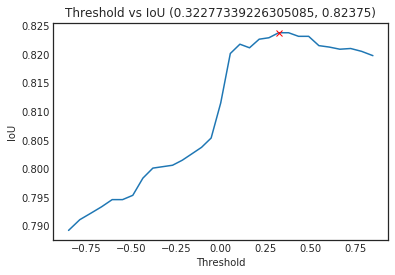

In [28]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))

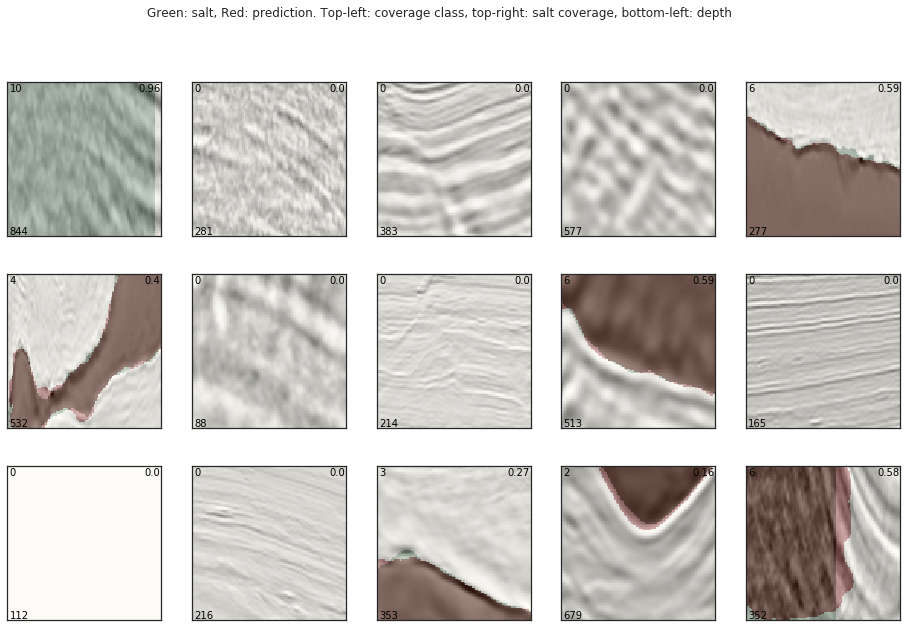

In [29]:
preds_thresh_iter = map(
    lambda pred: np.array(np.round(pred > threshold_best), dtype=np.float32),
    preds_valid,
)
preds_thresh = np.array(list(preds_thresh_iter))

plot_predictions(
    train_df, preds_thresh, ids_valid, max_images=15, grid_width=5, figsize=(16, 10)
)

plt.legend()

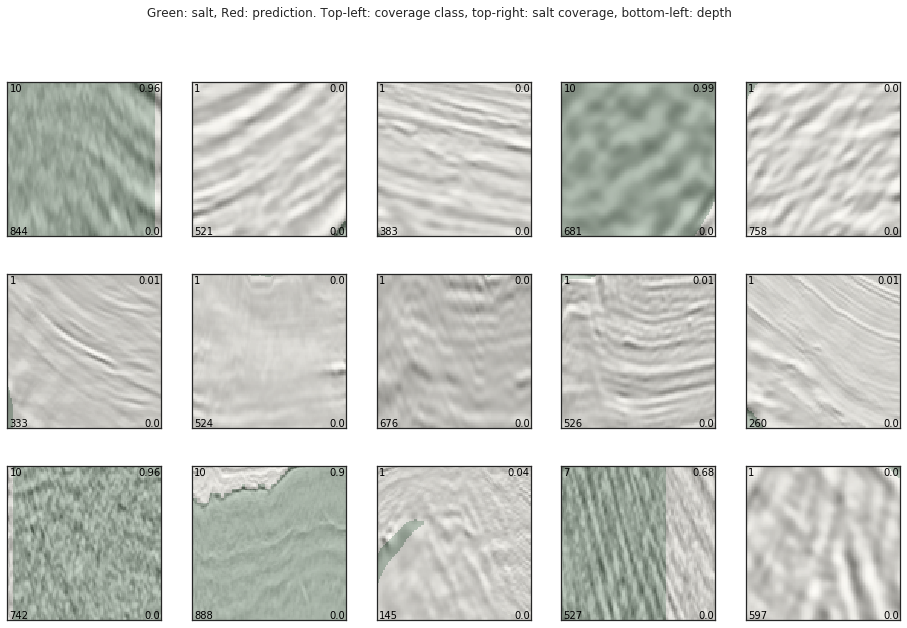

In [30]:
plot_poor_predictions(train_df, preds_thresh, y_valid_down, ids_valid, max_images=15, grid_width=5, figsize=(16, 10))

In [31]:
dd = train_df.loc[ids_valid]

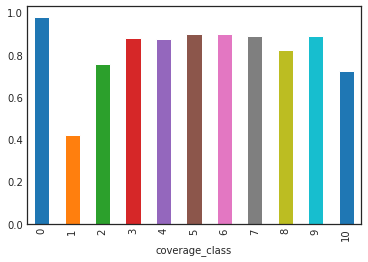

In [32]:
dd.groupby('coverage_class').mean().iou.plot(kind='bar')

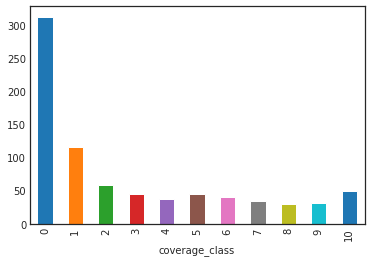

In [33]:
dd.groupby('coverage_class').count().z.plot(kind='bar')

In [34]:
dd['iou'].mean()

0.834252156324476

In [35]:
# write best threshold to config
config = load_config()
config['EvaluateModel']['threshold']=threshold_best
save_config(config)

INFO:config:Loading config ../configs/config.json
INFO:config:Saving config ../configs/config.json
INFO:config:{
    "EvaluateModel": {
        "base_channels": 32,
        "batch_size": 128,
        "id": "61464e07-ce3e-42b1-b88a-482d645756d8",
        "img_target_size": 101,
        "initial_model_filename": "best_lovasz_model.pth",
        "name": "EvaluateModel",
        "num_workers": 0,
        "seed": 42,
        "threshold": 0.32277339226305085
    },
    "Model": {
        "base_channels": 32,
        "batch_size": 128,
        "best_model_filename": "best_model_state.pth",
        "epochs": 70,
        "id": "61464e07-ce3e-42b1-b88a-482d645756d8",
        "img_target_size": 101,
        "model_filename": "model_{cycle}_state.pth",
        "num_workers": 0,
        "optimization_config": {
            "base_lr": 0.1,
            "momentum": 0.9,
            "nesterov": true,
            "scheduler": {
                "lr_min": 0,
                "num_cycles": 6,
              